In [1]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg
from matplotlib import gridspec
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatch

import matplotlib.transforms as mtransforms

In [2]:
import gc

In [3]:
from djPyi2 import pandas_methods as pm

In [4]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [5]:
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [23]:
def prep_info_long(info_long, sample_info):
    """ prep of long dataframe with one line per sample/CNV """
    info_long = info_long.copy()
    
    study_dict = sample_info.STUDY.to_dict()
    info_long['STUDY'] = info_long.SAMPLE.apply(lambda x: study_dict[x])
    info_long = info_long[info_long.STUDY != 'HLI']

    info_long['unique_id'] = info_long.SAMPLE + '-' + info_long.ID
    info_long.index = info_long.unique_id
    info_long['SVTYPE'] = info_long.CN.apply(lambda x: 'DUP' if x > 2 else 'DEL')

    info_long = info_long[info_long.CN != 2.0]
    info_long_filt = info_long[~((info_long.COVERAGE < 2.75) & (info_long.COVERAGE > 2))]
    info_long_filt = info_long_filt[~((info_long_filt.COVERAGE < 2) & (info_long_filt.COVERAGE > 1.25))]
    

    
    return info_long_filt

In [24]:
def generate_per_pair_summary(df):
    df = df.copy()
    if 'ID' in df.columns:
        df = df.drop('ID', axis = 1)
        
    df = df.apply(pd.value_counts).T.stack().to_frame('counts').reset_index()
    names = ['pair', 'category', 'counts']
    df.columns = names
    df = df.pivot_table(values = 'counts', index = 'pair', columns = ['category'])
    
    for c in df.columns:
        df[c] = df[c].fillna(0).astype(int)
    
    df['total_variants'] = df.CONCORDANT + df.DISCORDANT
    df['percent_concordant'] = df.CONCORDANT/ df.total_variants
    return df

In [25]:
def split_id_to_coord(ID):
    spl = ID.split('_')
    chrom = spl[1]
    start = int(spl[2])
    end = int(spl[3])
    return chrom, start, end

def get_merged_length(bt_list):
    """make a bt from python list of tab sep positions (chr start end), merge overlapping positions, 
    and compute total length covered"""
    bt_str = '\n'.join(bt_list)
    bt =  pbt.BedTool(bt_str, from_string=True).sort()
    tdf = bt.merge()
    tdf = tdf.to_dataframe()
    tdf = tdf.drop_duplicates(['chrom', 'start', 'end'])
    tdf['length'] = tdf.end - tdf.start

    length_sum = tdf.length.sum()
    return length_sum

def compute_merged_length_from_cnv_set(per_sample_cnvs):
    """ compute the merged length covered from a set of tab separated positions
    DUP and DEL contain list of tab separated coords-
    convert these to bedtools with pybedtool, merge them and compute
    combined length
    this step ensures any overlapping variants in an individual do not over-estimate total burden"""
    
    data = []
    for i,x in per_sample_cnvs.iterrows():
        dels = x['DEL']
        dups = x['DUP']

        if len(dels) > 0:
            length_del = get_merged_length(dels)
        else:
            length_del = 0
        
        if len(dups) > 0:
            length_dup = get_merged_length(dups)
        
        else:
            length_dup = 0
            
        
        data.append([i, length_del, length_dup])
    return pd.DataFrame(data, columns=['sample', 'DEL', 'DUP'])

def calculate_bp_coverage_per_sample(info_merged, sample_info):
    """calculate per sample total bp coverage of deletions and duplications (burden)
    subset info_merged as neccessary (excluding constituent sites for example)"""
    
    
    data_dict = {i:{'DUP': [], 'DEL':[]} for i in sample_info[(sample_info.STUDY != 'HLI') & (sample_info.CELL_TYPE !='iPSC')].WGS_ID.tolist()}
    for i, x in info_merged[info_merged.constituent_site == False].iterrows():
        cn_dicts = x['CN_SAMPLES'] 
        length = x['LENGTH']
        coord = split_id_to_coord(i)
        formatted_id = "\t".join(list(map(str,coord)))

        for k,v in cn_dicts.iteritems():
            if v < 2:

                data_dict[k]['DEL'].append(formatted_id)
            if v > 2:
                data_dict[k]['DUP'].append(formatted_id)

    per_sample_cnvs = pd.DataFrame(data_dict).T
    per_sample_burden = compute_merged_length_from_cnv_set(per_sample_cnvs)
    per_sample_cnvs['CNVs_DEL'] = per_sample_cnvs['DEL']
    per_sample_cnvs['CNVs_DUP'] = per_sample_cnvs['DUP']
    per_sample_cnvs['DEL'] = per_sample_cnvs.DEL.apply(lambda x: len(x))
    per_sample_cnvs['DUP'] = per_sample_cnvs.DUP.apply(lambda x: len(x))
    per_sample_burden.index = per_sample_burden['sample']
    
    return per_sample_burden, per_sample_cnvs

In [26]:
def modify_per_sample(df, sample_info):
    
    df = df.copy()
    df['sample'] = df.index
#     df.index = df['sample']
    cols = ['CELL_TYPE', 'STUDY','SEX', 'GENETICALLY_SIMILAR_POPULATION_GROUP']
    def mod_ethnicity(x):
        if x == 'AFR':
            return 'African'
        else:
            return 'Non African'
        
    df = df.join(sample_info[cols])
    df['ethnicity_mod'] = df['GENETICALLY_SIMILAR_POPULATION_GROUP'].apply(lambda x: mod_ethnicity(x))
    
    df = df.sort_values(['STUDY', 'CELL_TYPE', 'ethnicity_mod', 'SEX','sample'])
    df['x'] = range(df.shape[0])
    return df

In [10]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

study_dict = sample_info.STUDY.to_dict()

In [11]:
info_unfilt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_processing/gs_lcnv_long.pkl')
info_unfilt = info_unfilt.pipe(pm.concat_cols, ['CHROM', 'START', 'END'], name = 'ID')
info_unfilt['ID'] = 'CNV' + '_' + info_unfilt.ID

In [12]:
info_filt_long = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_processing/gs_lcnv_filt_long.pkl')

tdf =prep_info_long(info_filt_long, sample_info)

In [13]:
info_merged = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/gs_lcnv_info_merged.pkl')

In [14]:
info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_processing/gs_lcnv_info.pkl')

info = info[info.cent_overlap_type.isin(['UPSTREAM', 'DOWNSTREAM', 'OVERLAPS_LEFT', 'OVERLAPS_RIGHT'])]

In [19]:
info_merged_annot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_final_vcf/gs_lcnv_info_merged_annot_final.pkl')

In [15]:
intersect_info= pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/intersect_info_lcnv_merging.pkl')

In [16]:
tdf = tdf[tdf.ID.isin(info.ID.unique())]
info_filt_ci = info[info.ID.isin(tdf.ID.unique())]

In [20]:
info_merged_annot[info_merged_annot.constituent_site == False].shape

(432, 39)

In [28]:
per_sample_burden, per_sample_cnvs = calculate_bp_coverage_per_sample(info_merged_annot[info_merged_annot.constituent_site==False], sample_info)

In [29]:
per_sample_cnvs = per_sample_cnvs.pipe(modify_per_sample, sample_info)

In [34]:
exclude = sample_info[sample_info.not_consented].WGS_ID.tolist()
per_sample_cnvs = per_sample_cnvs[~per_sample_cnvs['sample'].isin(exclude)]

In [35]:
per_sample_cnvs.DEL.describe()

count    472.000000
mean       4.186441
std        1.891760
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       11.000000
Name: DEL, dtype: float64

In [36]:
per_sample_cnvs.DUP.describe()

count    472.000000
mean       2.019068
std        1.264263
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: DUP, dtype: float64

# Filtering numbers 

we called initially 1117 distinct LCNV that are filtered to 781 with SCORE => 1000 and NBINS >= 10.  These were filtered to 681 that are CN > 2.75 or CN < 1.25 -  and then 658 that are not contained within the centromere or fully overlap the centromere- These were used to then combine by merging breakpoints that with RO >=0.8- and assigning a breakpoint with the min start and max end position of all cnvs in the cluster- but carrying over the copy number genotypes from the constituents.  This resulted in 73 merge sites comprised of 299 original distinct sites.  The set then contained 432 CNVs.  We then intersected those with LUMPY and Genome STRiP variants (CNVDiscovery) and if the variant was discovered in one of these sets, the GS_LCNV cnv was marked as part of a non-redundant cluster with them- in which it was not the primary variant (as these CNVs have less accurate breakpoints).  309 of these variants weren't seen in GS or LUMPY call sets (RO = 0.5)

In [254]:
stages = [info_unfilt.ID.unique().shape[0], 
          info_filt_ci.shape[0], 
          info_merged_annot[info_merged_annot.constituent_site==False].shape[0],
         info_merged_annot[(info_merged_annot.constituent_site==False) & 
                           (info_merged_annot.MC_cluster_all == False)].shape[0]]

labels = ['Unfiltered', 'Filtered', 'Collapse Overlaps', 'Non Redundant']

p = pd.Series(dict(zip(labels, stages))).to_frame('No. Variants').loc[labels]

p['Stage'] = p.index

In [258]:
p

,No. Variants,Stage
Unfiltered,1117,Unfiltered
Filtered,658,Filtered
Collapse Overlaps,432,Collapse Overlaps
Non Redundant,141,Non Redundant


In [270]:
nr_lcnv_mc = info_merged_annot[(info_merged_annot.constituent_site==False) & 
                           (info_merged_annot.MC_cluster_all == False)].ID.tolist()

In [5]:
gs_lcnv_info_merged = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/gs_lcnv_info_merged.pkl')

In [12]:
cluster_info_lcnv = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/cluster_info_lcnv.pkl')

In [13]:
intersect_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/intersect_info_lcnv_merging.pkl')

In [ ]:
num_merged_per = cluster_info_lcnv.num_in_clust.value_counts().sort_index()
num_merged_per = num_merged_per.to_frame('No. Clusters')
num_merged_per['No. Sites in Cluster'] = num_merged_per.index

In [295]:
non_redun = info_merged_annot[info_merged_annot.constituent_site == False].ID.tolist()

In [311]:
info_merged_nr = info_merged_annot[info_merged_annot.constituent_site == False]

info_merged_nr['log10_SVLEN'] = np.log10(info_merged_annot.LENGTH)

# Plot functions

In [340]:
def plot_per_sample_barplot(df, order_of_cols, colors, ax, axsubx):

    df[order_of_cols].plot(kind='bar', stacked =True, ax = ax, colors = colors)
    ax.set_xticklabels('')
    ax.tick_params(axis = 'x', top = False, bottom = False)
    ax.tick_params(axis = 'y', width = 1, length = 3)
    ax.xaxis.grid(False)

    leg = ax.legend(bbox_to_anchor = (1,1), loc = 'upper left', frameon=True)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')

    group_order = ['STUDY', 'CELL_TYPE', 'ethnicity_mod']
    study_color_dict = {'HipSci': '#96b9f2', 'iPSCORE': '#95f1b0', 'HLI':'black'}
    ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
    cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
    color_dict_order = [study_color_dict, cell_type_color_dict, ethnicity_color_dict]
    bottoms = [-200, -400, -600]
    heights = [200, 200, 200]
    label_bools = [True, False, False]


#     d_ranges_study = dict_gb_ranges(df, 'STUDY')

#     divider = make_axes_locatable(ax)

#     axsubx = divider.append_axes("bottom", size=0.4, pad=0)
    x_min, x_max = ax.get_xlim()
    axsubx.set_xlim(x_min, x_max)
    axsubx.set_ylim(-700,0)
    mpltools.annotate_multi_level(axsubx, df, group_order, color_dict_order, bottoms, heights, label_bools)
    axsubx.set_axis_off()
    return ax, axsubx, leg

In [178]:
info_merged_annot[info_merged_annot.MC_cluster_all == False].shape

(309, 39)

In [179]:
rr_per_site_all_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_processing/rr_per_site_all_twins.pkl')

In [293]:
rr_per_pair_all_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_processing/rr_per_pair_all_twins.pkl')

In [277]:
inds = rr_per_site_all_twins[rr_per_site_all_twins.replication_rate != 'None'].name.tolist()

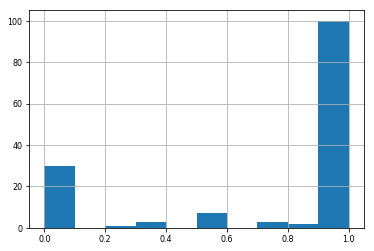

In [282]:
rr_per_site_all_twins.loc[inds].replication_rate.astype(float).hist()

In [297]:
rr_pp_filt = rr_per_pair_all_twins.loc[non_redun]

In [300]:
pp_summary = generate_per_pair_summary(rr_pp_filt)

In [189]:
tdf = info_merged_annot.loc[inds]

In [199]:
nr = tdf[tdf.constituent_site == False]

In [194]:
del independent

In [204]:
rr_filt = rr_per_site_all_twins.loc[nr.index]

(69, 13)

In [206]:
rr_filt['replication_rate']  = rr_filt['replication_rate'].astype(float)

In [274]:
rr_nr = rr_filt[rr_filt.index.isin(nr_lcnv)]

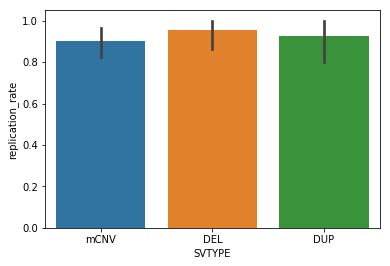

In [209]:
sns.barplot(x= 'SVTYPE', y = 'replication_rate', data = rr_filt)

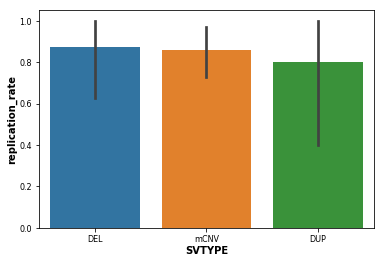

In [275]:
sns.barplot(x= 'SVTYPE', y = 'replication_rate', data = rr_nr)

In [214]:
nr[nr.MC_cluster_all == False].shape

(26, 39)

In [208]:
rr_filt.groupby('SVTYPE').replication_rate.mean()

SVTYPE
DEL     0.954545
DUP     0.925000
mCNV    0.902632
Name: replication_rate, dtype: float64

In [141]:
tdf = tdf[tdf.ID.isin(info.ID.unique())]

info_filt_ci = info[info.ID.isin(tdf.ID.unique())]

In [162]:
658 + 73

731

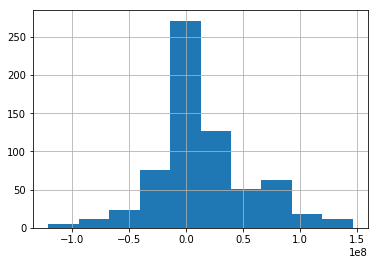

In [158]:
info_filt_ci[info_filt_ci.cent_overlap_type == '']

In [161]:
info_filt_ci.cent_overlap_type.value_counts()

UPSTREAM          370
DOWNSTREAM        273
OVERLAPS_LEFT       8
OVERLAPS_RIGHT      7
Name: cent_overlap_type, dtype: int64

In [37]:
info_merged_annot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_final_vcf/gs_lcnv_info_merged_annot_final.pkl')

In [71]:
lcnv_per_sample_num = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_lcnv_merging/lcnv_per_sample_num.pkl')

In [38]:
info_merged_annot[(info_merged_annot.MC_cluster == False) & (info_merged_annot.constituent_site == False)]

,CHROM,START,END,ID,ID_Mod,LENGTH,cluster_id,collapsed_site,UUIDs_NREF,NREF,COVERAGE_SAMPLES,CN_SAMPLES,constituent_site,is_collapsed_site,cluster_str,SCORE,NBINS,NREF_PERC,ALLELES_PRESENT,SVTYPE,cn_mode,SAMPLES_NREF_RNA,SAMPLES_NREF_hipsci_fib,SAMPLES_NREF_i2QTL,SAMPLES_NREF_i2QTL_unrel,SAMPLES_NREF_ipscore,NREF_RNA,MAF_RNA,NREF_hipsci_fib,MAF_hipsci_fib,NREF_i2QTL,MAF_i2QTL,NREF_i2QTL_unrel,MAF_i2QTL_unrel,NREF_ipscore,MAF_ipscore,ID_original,MC_cluster,MC_cluster_all
ID_Mod,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CNV_1_604061_851158_Original,1,604061,851158,CNV_1_604061_851158_Original,CNV_1_604061_851158_Original,247097,0,CNV_1_604061_851158_Original,"[251a999a-05dd-4ad8-a530-c188ecc5b795, 694fce3...",2,{u'251a999a-05dd-4ad8-a530-c188ecc5b795': 2.93...,"{u'251a999a-05dd-4ad8-a530-c188ecc5b795': 3.0,...",False,False,False,1562.675,13,0.004193,[3.0],DUP,2,[251a999a-05dd-4ad8-a530-c188ecc5b795],[],"[251a999a-05dd-4ad8-a530-c188ecc5b795, 694fce3...",[251a999a-05dd-4ad8-a530-c188ecc5b795],"[251a999a-05dd-4ad8-a530-c188ecc5b795, 694fce3...",1,0.002410,0,0.000000,2,0.004193,1,0.002695,2,0.007326,CNV_1_604061_851158,False,False
CNV_1_12838794_13048788_Original,1,12838794,13048788,CNV_1_12838794_13048788_Original,CNV_1_12838794_13048788_Original,209994,47,CNV_1_12838794_13048788_Collapsed,"[a5b3835e-ee57-43cc-ab9b-7bbafdd54284, 9065798...",2,{u'90657981-484d-444a-9b2b-9b479f84c8c6': 0.96...,"{u'90657981-484d-444a-9b2b-9b479f84c8c6': 1.0,...",True,False,"CNV_1_12838794_13048788_Original,CNV_1_1285078...",1287.305,11,0.004193,[1.0],DEL,2,"[a5b3835e-ee57-43cc-ab9b-7bbafdd54284, 9065798...",[],"[a5b3835e-ee57-43cc-ab9b-7bbafdd54284, 9065798...",[a5b3835e-ee57-43cc-ab9b-7bbafdd54284],"[a5b3835e-ee57-43cc-ab9b-7bbafdd54284, 9065798...",2,0.004819,0,0.000000,2,0.004193,1,0.002695,2,0.007326,CNV_1_12838794_13048788,False,False
CNV_1_12850787_13048788_Original,1,12850787,13048788,CNV_1_12850787_13048788_Original,CNV_1_12850787_13048788_Original,198001,47,CNV_1_12838794_13048788_Collapsed,"[f3284741-0362-4f47-8ee8-191acf41d7ac, 3e87ef5...",3,{u'3e87ef5c-48bc-4e37-a89d-2b71f6afa8f6': 3.03...,"{u'3e87ef5c-48bc-4e37-a89d-2b71f6afa8f6': 3.0,...",True,False,"CNV_1_12838794_13048788_Original,CNV_1_1285078...",1691.360,10,0.006289,[3.0],DUP,2,"[f3284741-0362-4f47-8ee8-191acf41d7ac, 3e87ef5...",[],"[f3284741-0362-4f47-8ee8-191acf41d7ac, 3e87ef5...","[f3284741-0362-4f47-8ee8-191acf41d7ac, 3e87ef5...","[f3284741-0362-4f47-8ee8-191acf41d7ac, 3e87ef5...",3,0.007229,0,0.000000,3,0.006289,3,0.008086,3,0.010989,CNV_1_12850787_13048788,False,False
CNV_1_14411228_14652189_Original,1,14411228,14652189,CNV_1_14411228_14652189_Original,CNV_1_14411228_14652189_Original,240961,0,CNV_1_14411228_14652189_Original,[SAMEA2555011],1,{u'SAMEA2555011': 2.96},{u'SAMEA2555011': 3.0},False,False,False,3206.270,24,0.002096,[3.0],DUP,2,[SAMEA2555011],[SAMEA2555011],[SAMEA2555011],[SAMEA2555011],[],1,0.002410,1,0.004902,1,0.002096,1,0.002695,0,0.000000,CNV_1_14411228_14652189,CNV_1_14438643_14643980_Stitched,"CNV_1_14438643_14643980_Stitched,DUP_1_1440818..."
CNV_1_25304729_25613744_Original,1,25304729,25613744,CNV_1_25304729_25613744_Original,CNV_1_25304729_25613744_Original,309015,0,CNV_1_25304729_25613744_Original,[00ac22e8-826e-49df-8216-04571b00ac21],1,{u'00ac22e8-826e-49df-8216-04571b00ac21': 2.88},{u'00ac22e8-826e-49df-8216-04571b00ac21': 3.0},False,False,False,5879.520,30,0.002096,[3.0],DUP,2,[00ac22e8-826e-49df-8216-04571b00ac21],[],[00ac22e8-826e-49df-8216-04571b00ac21],[00ac22e8-826e-49df-8216-04571b00ac21],[00ac22e8-826e-49df-8216-04571b00ac21],1,0.002410,0,0.000000,1,0.002096,1,0.002695,1,0.003663,CNV_1_25304729_25613744,CNV_1_25329228_25579525_Stitched,CNV_1_25329228_25579525_Stitched


In [52]:
inds = info_merged_annot[info_merged_annot.MC_cluster_all != False].collapsed_site.unique().tolist()

In [57]:
info_uniq = info_merged_annot[~info_merged_annot.collapsed_site.isin(inds)]

In [62]:
info_merged_annot[info_merged_annot.is_collapsed_site == False].shape

(658, 39)

In [63]:
info_merged_annot[info_merged_annot.is_collapsed_site].shape

(73, 39)

In [85]:
cluster_info_lcnv.num_in_clust.value_counts

,clust,num_in_clust,merge_site,cnvs_in_merge,other_cnvs,num_other,color_dict_all,ls_dict
0,"[CNV_7_111230085_111331383, CNV_7_111230085_11...",2,CNV_7_111230085_111341400,"[CNV_7_110874380_111281320, CNV_7_111230085_11...",{CNV_7_110874380_111281320},1,{u'CNV_7_111230085_111331383': (0.105882352941...,"{u'CNV_7_111230085_111331383': u'-', u'CNV_7_1..."
1,"[CNV_4_69369823_69508142, CNV_4_69349823_69487...",9,CNV_4_69349823_69518697,"[CNV_4_69349823_69487607, CNV_4_69349823_69497...",{},0,{u'CNV_4_69369823_69508142': (0.45882352941176...,"{u'CNV_4_69369823_69508142': u'-', u'CNV_4_693..."
2,"[CNV_15_20627249_22381827, CNV_15_20886577_223...",9,CNV_15_20627249_22381827,"[CNV_15_20627249_21009005, CNV_15_20627249_212...","{CNV_15_20886577_23514853, CNV_15_20962559_213...",8,{u'CNV_15_20886577_23514853': (0.8509803921568...,"{u'CNV_15_20886577_23514853': u'--', u'CNV_15_..."
3,"[CNV_9_43612111_43838185, CNV_9_43540099_43838...",10,CNV_9_43540099_43946569,"[CNV_9_40816961_43838185, CNV_9_43180545_43612...","{CNV_9_43313699_43595192, CNV_9_43420885_43630...",17,{u'CNV_9_43580829_43797857': (0.10588235294117...,"{u'CNV_9_43580829_43797857': u'-', u'CNV_9_435..."
4,"[CNV_8_39215187_39407299, CNV_8_39235193_39427...",19,CNV_8_39185117_39427382,"[CNV_8_39185117_39387299, CNV_8_39195117_39387...",{},0,{u'CNV_8_39215187_39407299': (0.45882352941176...,"{u'CNV_8_39215187_39407299': u'-', u'CNV_8_392..."


In [90]:
info_merged_annot.shape

(731, 39)

In [67]:
info_merged_annot[info_merged_annot.constituent_site == True].shape

(299, 39)

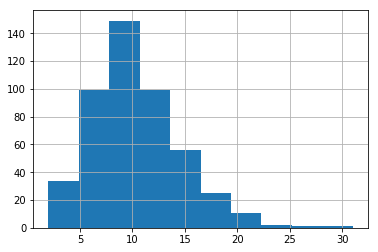

In [70]:
info_unfilt.SAMPLE.value_counts().hist()

In [265]:
num_merged_per = cluster_info_lcnv.num_in_clust.value_counts().sort_index()

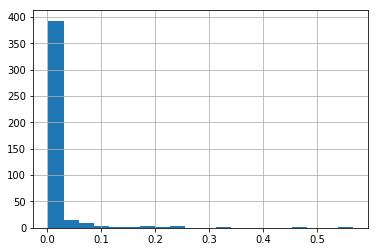

In [32]:
gs_lcnv_info_merged[gs_lcnv_info_merged.constituent_site == False].NREF_PERC.hist(bins = 20)

In [91]:
gs_lcnv_info_merged[gs_lcnv_info_merged.LENGTH == gs_lcnv_info_merged.LENGTH.max()]

,CHROM,START,END,ID,ID_Mod,LENGTH,cluster_id,collapsed_site,UUIDs_NREF,NREF,COVERAGE_SAMPLES,CN_SAMPLES,constituent_site,is_collapsed_site,cluster_str,SCORE,NBINS,NREF_PERC,ALLELES_PRESENT,SVTYPE,cn_mode
ID_Mod,,,,,,,,,,,,,,,,,,,,,
CNV_1_188333648_195825761_Original,1,188333648,195825761,CNV_1_188333648_195825761,CNV_1_188333648_195825761_Original,7492113,0,CNV_1_188333648_195825761_Original,[SAMEA2398117],1,{u'SAMEA2398117': 3.0},{u'SAMEA2398117': 3.0},False,False,False,95005.92,742,0.002096,[3.0],DUP,2


# Palettes

In [359]:
study_color_dict = {'HipSci': '#96b9f2', 'iPSCORE': '#95f1b0', 'HLI':'black'}
ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
colors_underbar_dict = study_color_dict
colors_underbar_dict.update(ethnicity_color_dict)
colors_underbar_dict.update(cell_type_color_dict)

color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()

In [365]:
pal = {'DEL': 'red', 'DUP': 'green', 'mCNV':'orange'}

# Figure

In [218]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8

mpl.rcParams['axes.labelweight'] = 'bold'


mpl.gridspec.rcParams['axes.labelpad'] = 2
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 10
mpl.gridspec.rcParams['ytick.labelsize'] = 8
mpl.gridspec.rcParams['xtick.labelsize'] = 8
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'

In [317]:
def format_easy_read_log(x, log10 = False, rounding = 1, ints = False):
    """ input list of tick locations, output formatted ticks 
    with bp,kbpb, MB annotations - log: if the ticks
    are log scaled- what base is the log scale 
    example: log=10 for log base 10"""
    if log10:
        input_ticks = [(10**i) for i in x]
    else:
        input_ticks = x    
    out = []
    for t in input_ticks: 
        if t < 1000:
            if not ints:
                f = copy.deepcopy(t)
            else:
                f = int(t)
        
        elif t > 100000:
            if not ints:
                f = "{}M".format(round((t/1000000), rounding))
            else:
                f = "{}M".format(int(round((t/1000000), rounding)))
            
        elif t >= 1000:
            if not ints:
                f = "{}K".format(round((t/1000), rounding))
            else:
                 f = "{}K".format(int(round((t/1000), rounding)))
            
        else:
            return 'missed case'
        out.append(f)
    
    return out



/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


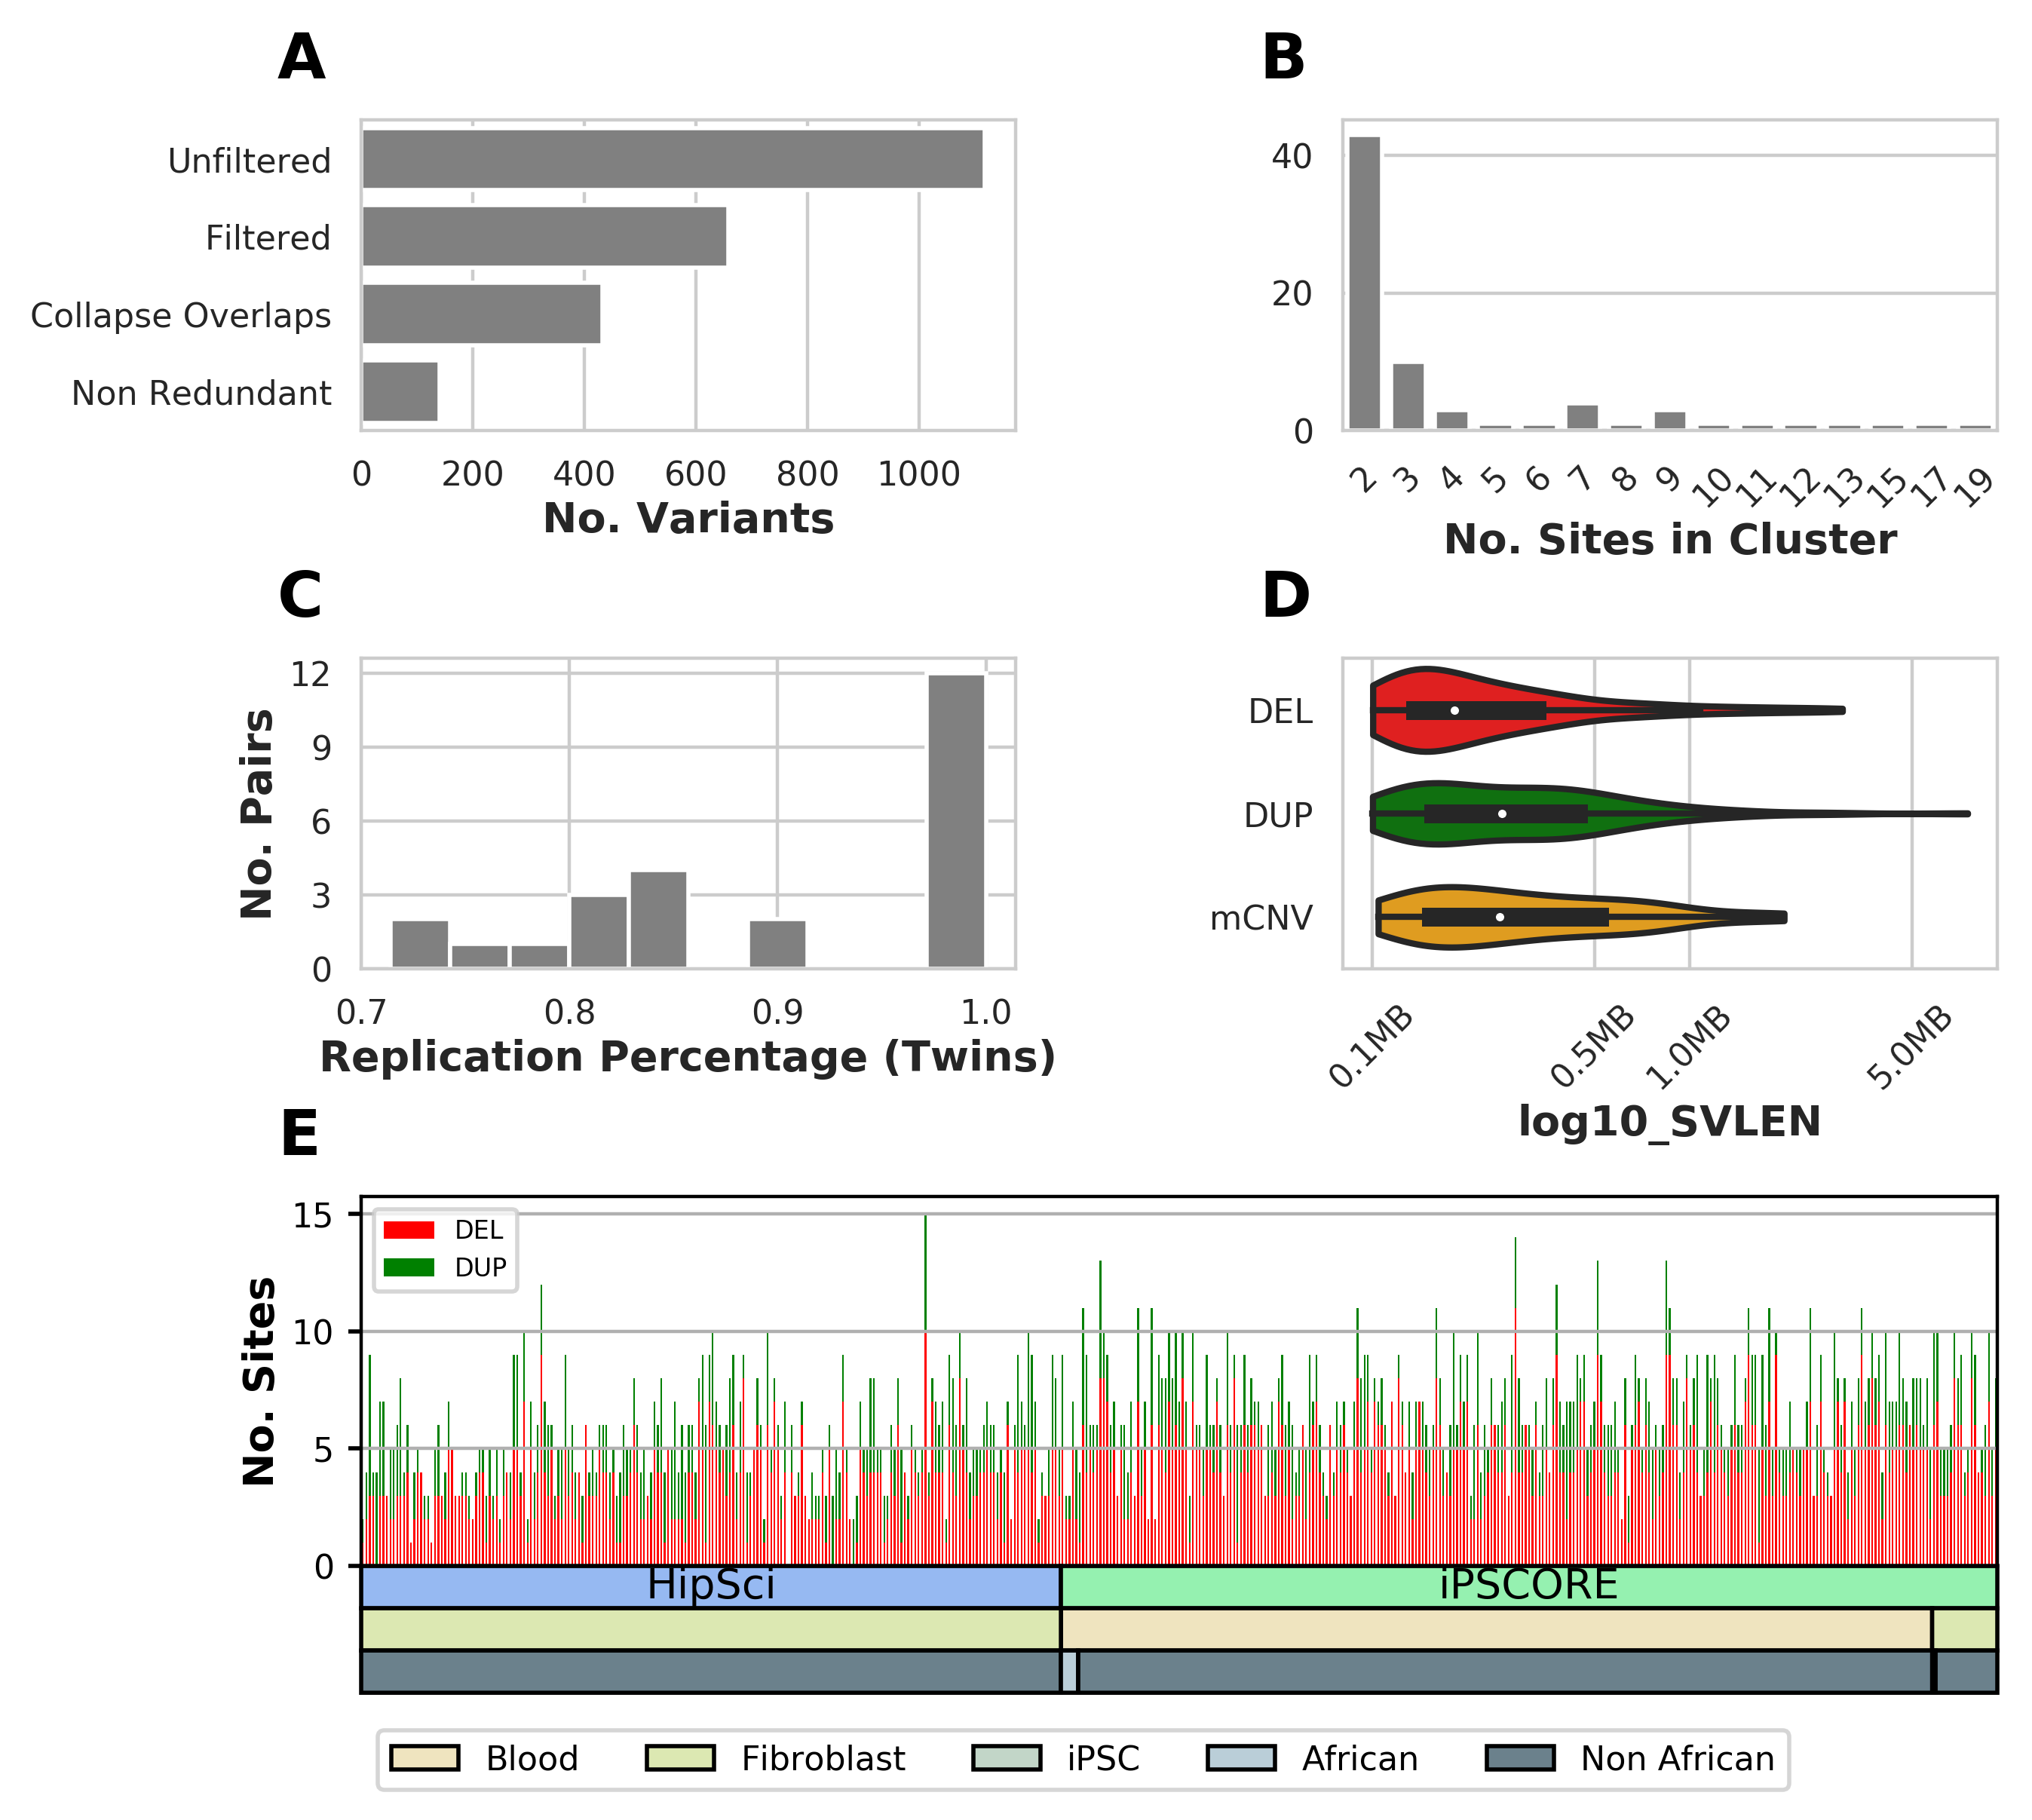

In [389]:
fig =plt.figure(figsize=(7,7), dpi = 400)
gs = mpl.gridspec.GridSpec(3, 2, 
                           figure =fig,
                           width_ratios=[1, 1], height_ratios=[0.6,0.6, 1], wspace = 0.5, hspace=0.6)


# ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[0,1])
with sns.axes_style('whitegrid'):
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax1.xaxis.grid(zorder=0)
    ax2.xaxis.grid(zorder=0)
    
    
    ax1 = sns.barplot(y = 'Stage', x = 'No. Variants', data = p, ax =ax1, color = 'grey')
    ax1.set_ylabel('')

    ax2 = sns.barplot(y = 'No. Clusters', x = 'No. Sites in Cluster', data = num_merged_per, 
                      ax =ax2, color = 'grey')
    ax2.set_ylabel('')
    ax2.tick_params(axis= 'x', labelrotation = 45)

    ax3 = fig.add_subplot(gs[1,0])
    ax3.hist(pp_summary.percent_concordant, bins = 10, color = 'grey')
    ax3.set_xlabel('Replication Percentage (Twins)')
    ax3.set_yticks(np.arange(0,15, 3))
    ax3.set_ylabel('No. Pairs')    
    ax4 = fig.add_subplot(gs[1,1])

sns.violinplot(y = 'SVTYPE', x= 'log10_SVLEN', data = info_merged_nr, palette = pal,
              order = ['DEL', 'DUP', 'mCNV'], cut = 0)
locs =[100000, 500000, 1000000, 5000000]
t = mpltools.format_base_pair_scale(locs, log10=False)
xtick_locs = [np.log10(i) for i in locs]
ax4.set_xticks(xtick_locs)
ax4.set_xticklabels(t)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.set_ylabel('')

sg = gridspec.GridSpecFromSubplotSpec(2, 1,  width_ratios=[1], height_ratios=[1, 0.4], subplot_spec=gs[2,:], wspace=0.02, hspace=0)

ax3_a = fig.add_subplot(sg[0])
ax3_b = fig.add_subplot(sg[1])

c = ['DEL', 'DUP']

ax5_a, ax5_b, leg3 = plot_per_sample_barplot(per_sample_cnvs, 
                              c, [pal[i] for i in c], ax3_a, ax3_b)
ax5_a.legend(bbox_to_anchor= (0,1), loc = 'upper left', fontsize = 6)
ax5_a.yaxis.grid(zorder=0)
ax5_a.set_ylabel('No. Sites')
labels_underbar = ['Blood', 'Fibroblast', 'iPSC', 'African', 'Non African']
colors_underbar = [colors_underbar_dict[i] for i in labels_underbar]
patches = mpltools.get_legend_patches(labels_underbar, just_rect=True, rectfacecolor=colors_underbar)
leg = ax5_b.legend(handles = patches, bbox_to_anchor = [0,0], loc = 'upper left', ncol = 5, fontsize = 8,
                  title = '')


labels = ['A', 'B', 'C', 'D', 'E']
for i, a in enumerate([ax1, ax2, ax3, ax4, ax5_a]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 10)
    
out_fn = private_out + '/Supplemental_Figure_GS_LCNV_QC.png'
fig.savefig(out_fn, bbox_inches='tight', dpi = 400)


In [320]:
t

['31.6kb', '0.1MB', '0.32MB', '1.0MB', '3.16MB', '10.0MB', '31.62MB']

In [ ]:
mpltools.format_base_pair_scale()

In [290]:
num_merged_per

,No. Clusters,No. Sites in Cluster
2,43,2
3,10,3
4,3,4
5,1,5
6,1,6
7,4,7
8,1,8
9,3,9
10,1,10
11,1,11


In [286]:
num_merged_per = num_merged_per.to_frame('No. Clusters')

num_merged_per['No. Sites in Cluster'] = num_merged_per.index